In [1]:
import sys
sys.path.append('../misc')

from MoviaBusDataset import MoviaBusDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.init import kaiming_normal
from torch.utils.data import DataLoader
import numpy as np

In [2]:
prev_timesteps = 3
prediction_steps = 1

train = MoviaBusDataset('../data/train', interpolation=True, prev_timesteps=prev_timesteps, prediction_steps=prediction_steps)
test = MoviaBusDataset('../data/test', interpolation=True, prev_timesteps=prev_timesteps, prediction_steps=prediction_steps)

train.normalize()
test.normalize(train.mean, train.std)



In [11]:
train_DL = DataLoader(train, batch_size=50, shuffle=False)
test_DL = DataLoader(test, batch_size=len(test), shuffle=False)

In [9]:
num_input = (prev_timesteps + 1)

class FNN(nn.Module):
    def __init__(self, num_hidden1):
        super(FNN, self).__init__()
    
        self.l1 = nn.Linear(num_input, num_hidden1)
        self.l2 = nn.Linear(num_hidden1, num_hidden1)
        self.l3 = nn.Linear(num_hidden1, 1)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        
        x = self.activation(self.l1(x))
        x = self.dropout(x)
        x = self.activation(self.l2(x))
        x = self.dropout(x)
        x = self.l3(x)
        return x

net = FNN(100)

optimizer = optim.Adam(net.parameters(), lr=1e-4, weight_decay=0)
criterion = nn.L1Loss()

In [10]:
net.train()
for epoch in range(100):
    cur_loss = []
    for i , batch in enumerate(train_DL):
        output = net(batch['data'].transpose(2,1)).squeeze()[:,:-1]
        target = batch['target']

        optimizer.zero_grad()
        
        loss = criterion(output, target)   
        loss.backward()
        
        optimizer.step()
  
        cur_loss.append(loss.item())
    
    print("epoch = %2i  loss = %0.3f  output_std = %0.3f" %(epoch, np.mean(cur_loss), output.std().item()))

epoch =  0  loss = 0.764  output_std = 0.192
epoch =  1  loss = 0.750  output_std = 0.198
epoch =  2  loss = 0.738  output_std = 0.219
epoch =  3  loss = 0.728  output_std = 0.239
epoch =  4  loss = 0.719  output_std = 0.263
epoch =  5  loss = 0.712  output_std = 0.284
epoch =  6  loss = 0.705  output_std = 0.312
epoch =  7  loss = 0.700  output_std = 0.323
epoch =  8  loss = 0.694  output_std = 0.354
epoch =  9  loss = 0.692  output_std = 0.362
epoch = 10  loss = 0.688  output_std = 0.389
epoch = 11  loss = 0.685  output_std = 0.397
epoch = 12  loss = 0.683  output_std = 0.415
epoch = 13  loss = 0.680  output_std = 0.431
epoch = 14  loss = 0.678  output_std = 0.436
epoch = 15  loss = 0.677  output_std = 0.442
epoch = 16  loss = 0.675  output_std = 0.451
epoch = 17  loss = 0.675  output_std = 0.449
epoch = 18  loss = 0.675  output_std = 0.464
epoch = 19  loss = 0.673  output_std = 0.465
epoch = 20  loss = 0.672  output_std = 0.467
epoch = 21  loss = 0.671  output_std = 0.462
epoch = 22

In [12]:
net.eval()
for i, batch in enumerate(test_DL):
    
    output = net(batch['data'].transpose(2,1)).squeeze()[:,:-1]
    target = batch['target']
        
    output = (output + torch.tensor(train.mean))*torch.tensor(train.std)
    target = (target + torch.tensor(train.mean))*torch.tensor(train.std)
    
    loss = criterion(output,target)
    print(loss.item())

1.402906894683838


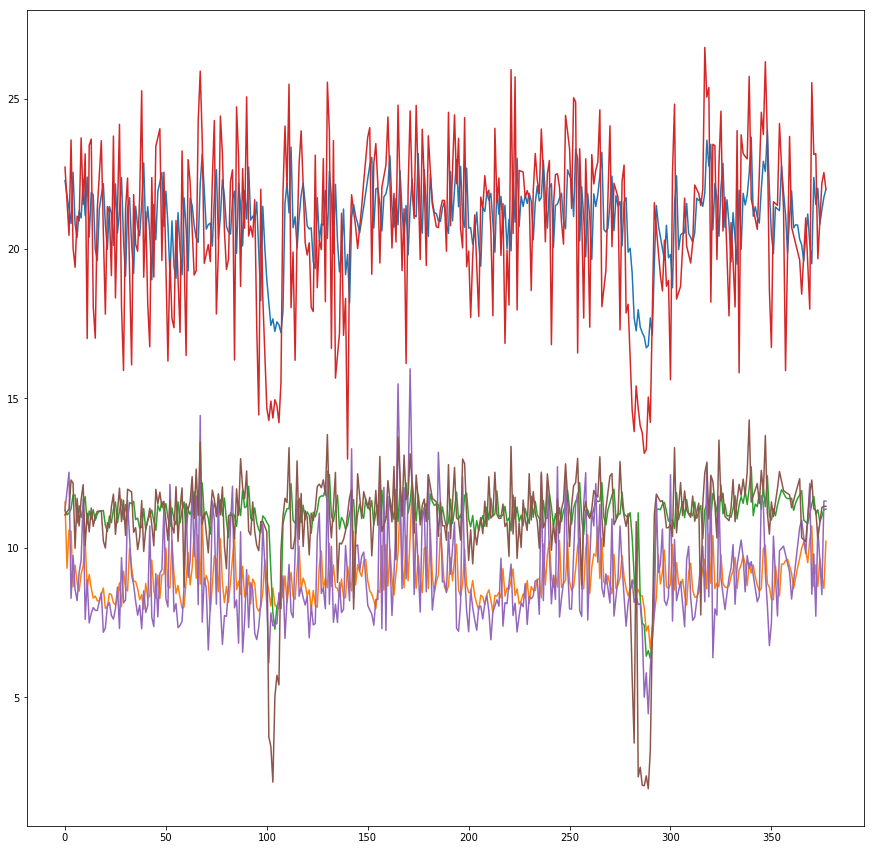

In [18]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

plt.plot(output[:,1:4].detach().numpy())
plt.plot(target[:,1:4].detach().numpy())